In [168]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import numpy as np
from scipy.signal import find_peaks

total time is 150.0 sec


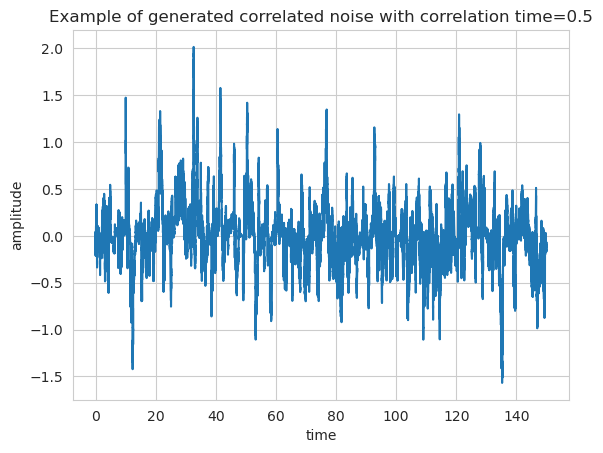

In [169]:
sampling_rate=2*1e3
sample_time=1/sampling_rate
N=300000


def ou_noise(n, dt=1.0, mu=0.0, tau=20.0, sigma=1.0, x0=0.0, rng=None):
    rng = np.random.default_rng(rng)
    x = np.empty(n)
    x[0] = x0
    a = np.exp(-dt / tau)
    sd = sigma * np.sqrt(1 - a*a)
    for t in range(1, n):
        x[t] = mu + a*(x[t-1] - mu) + sd * rng.normal()
    
    for i in range(len(x)):
        if i%int(tau/dt)==0:
            gain=random.randint(1,100)*0.01
        x[i]=x[i]*gain        
    return x

#Here tau sets the correlation time in seconds
tau=0.5
x = ou_noise(N, dt=sample_time, tau=tau, sigma=0.5)

time_array=np.linspace(0,sample_time*N,N)

plt.xlabel("time")
plt.ylabel("amplitude")
plt.title(f"Example of generated correlated noise with correlation time={tau}")
plt.plot(time_array,x)
print("total time is",sample_time*N,"sec")

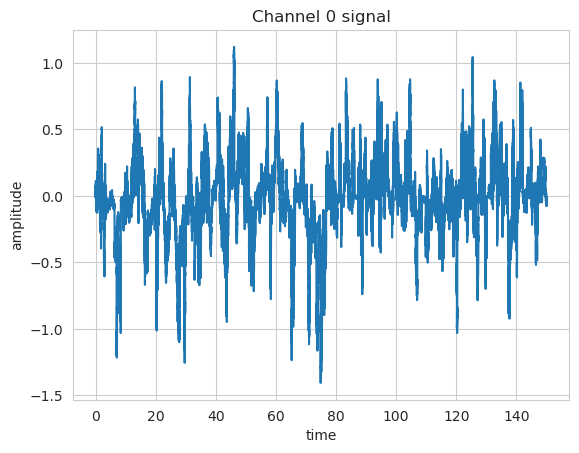

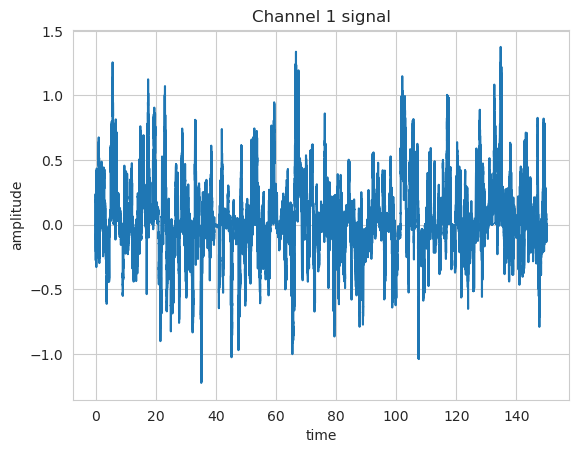

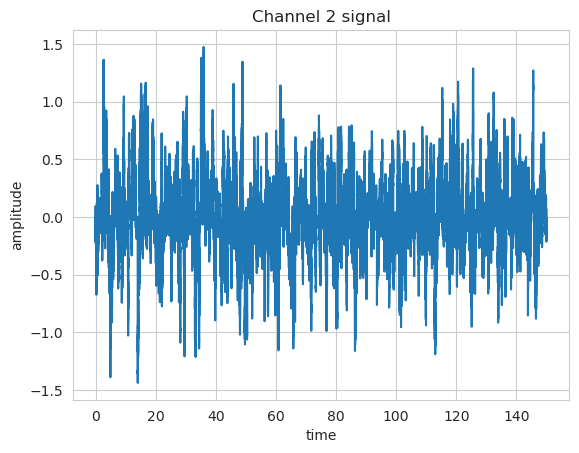

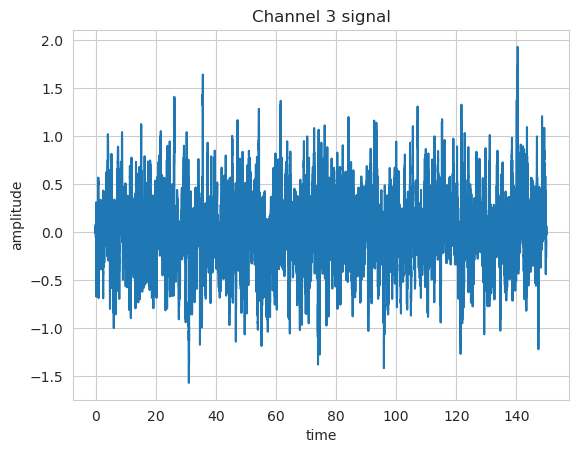

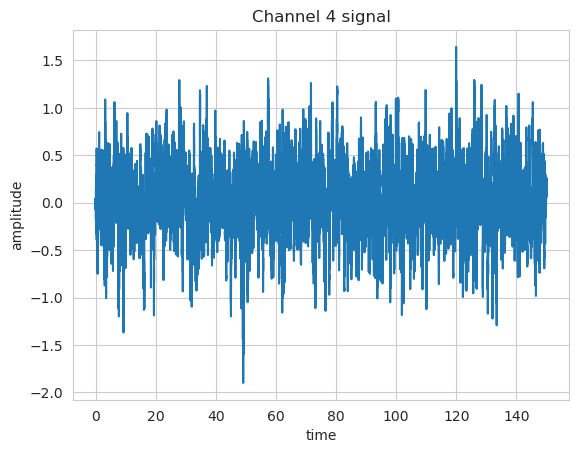

In [170]:
Channel_dict={}
num_channels=5
actual_coh_time={}

#generating Various channels with different coherence time values
Channel_dict[0]={'I':ou_noise(N,dt=sample_time,tau=0.7,sigma=0.5),'Q':ou_noise(N,dt=sample_time,tau=0.7,sigma=0.5)}
Channel_dict[1]={'I':ou_noise(N,dt=sample_time,tau=0.5,sigma=0.5),'Q':ou_noise(N,dt=sample_time,tau=0.5,sigma=0.5)}
Channel_dict[2]={'I':ou_noise(N,dt=sample_time,tau=0.2,sigma=0.5),'Q':ou_noise(N,dt=sample_time,tau=0.2,sigma=0.5)}
Channel_dict[3]={'I':ou_noise(N,dt=sample_time,tau=0.1,sigma=0.5),'Q':ou_noise(N,dt=sample_time,tau=0.1,sigma=0.5)}
Channel_dict[4]={'I':ou_noise(N,dt=sample_time,tau=0.1,sigma=0.5),'Q':ou_noise(N,dt=sample_time,tau=0.1,sigma=0.5)}



plt.title("Channel 0 signal")
plt.ylabel("amplitude")
plt.xlabel("time")
plt.plot(time_array,Channel_dict[0]["I"])
plt.show()


plt.title("Channel 1 signal")
plt.ylabel("amplitude")
plt.xlabel("time")
plt.plot(time_array,Channel_dict[1]["I"])
plt.show()


plt.title("Channel 2 signal")
plt.ylabel("amplitude")
plt.xlabel("time")
plt.plot(time_array,Channel_dict[2]["I"])
plt.show()


plt.title("Channel 3 signal")
plt.ylabel("amplitude")
plt.xlabel("time")
plt.plot(time_array,Channel_dict[3]["I"])
plt.show()


plt.title("Channel 4 signal")
plt.ylabel("amplitude")
plt.xlabel("time")
plt.plot(time_array,Channel_dict[4]["I"])
plt.show()


In [171]:
initial_scan_duration = int(30 / sample_time)        # 50 seconds simulated pre-scan
NOP_duration = int(10 / sample_time)       # 10 seconds simulated NOP
window_size_for_smoothening=50
number_samples_per_coherence_detection=int(5/sample_time)  #This refers to the size of block which I split my signal to find autocorrelation and average over
#Using min dwell time as 1sec This can be changed according to the hardware constraint on how fast we can change channels
min_dwell_samples=int(1/sample_time)



In [172]:
from numpy.fft import rfft, irfft

def autocorr_fft_smooth(x):
    """This function computes autocorrelation using FFT and then does smoothening using a average filter"""
    x = np.asarray(x)
    x = x - x.mean()  # optional, improves robustness
    n = len(x)
    nfft = 1 << (2 * n - 1).bit_length()  # next power of 2 for speed
    X = rfft(x, nfft)
    r = irfft(X * np.conj(X), nfft)[:n]  # non-negative lags
    r = r / (r[0] + 1e-20)  # normalize

    #Smoothening the data
    kernel = np.ones(window_size_for_smoothening) / window_size_for_smoothening
    r_smooth = np.convolve(r, kernel, mode='same')

    return r_smooth

def find_coh_time_fft_initial(x, threshold=1/3):
    """This function is used with the initial data from all channels it splits the signal into blocks of size number_samples_per_coherence_detection and then computes autocorrelation for each
    We take average of these values to get the true autocorrelation for each channel."""
    avg_array=[]
    for i in range(int(np.ceil(len(x)//number_samples_per_coherence_detection))):
        avg_array.append(autocorr_fft_smooth(x[number_samples_per_coherence_detection*i:number_samples_per_coherence_detection*(i+1)]))
    
    r=np.mean(avg_array,axis=0)
    idx = np.argmax(r <= threshold)  # returns 0 if first element meets
    if r[0] <= threshold:            # guard unlikely case
        return 0
    if idx == 0:                     # no drop found
        return len(r)                # cap at window length
    return idx

def find_coh_time_fft(x,threshold=1/3):
    """This function finds cohrence time directly without averaging we use this when we are updating the coherence time for each channel"""
    r=autocorr_fft_smooth(x)
    idx = np.argmax(r <= threshold)  # returns 0 if first element meets
    if r[0] <= threshold:            # guard unlikely case
        return 0
    if idx == 0:                     # no drop found
        return len(r)                # cap at window length
    return idx




In [173]:
def dfs_check_radar(signal):
    """Simulate radar detection by random chance."""
    return True


def initial_prescan_and_init_coherence(Channel_dict, scan_duration):
    """Perform DFS pre-scan + initial coherence estimation."""
    dfs_states = {}
    dfs_timers = {}
    dict_coherence_times = {}

    for ch in Channel_dict:
        # Simulate CAC (pre-scan)
        I_part = Channel_dict[ch]["I"][:scan_duration]
        Q_part = Channel_dict[ch]["Q"][:scan_duration]
        # radar_present = dfs_check_radar(I_part) or dfs_check_radar(Q_part)
        radar_present = False

        if radar_present:
            dfs_states[ch] = "NOP"
            dfs_timers[ch] = 0
        else:
            dfs_states[ch] = "AVAILABLE"
            dfs_timers[ch] = 0

        dict_coherence_times[ch] = {
            "I": find_coh_time_fft_initial(I_part),
            "Q": find_coh_time_fft_initial(Q_part),
        }

    return dfs_states, dfs_timers, dict_coherence_times

def prescan_and_coherence(Channel_dict, scan_duration):
    """This function is used online not while initialising"""
    dfs_states = {}
    dfs_timers = {}
    dict_coherence_times = {}

    for ch in Channel_dict:
        # Simulate CAC (pre-scan)
        I_part = Channel_dict[ch]["I"][:scan_duration]
        Q_part = Channel_dict[ch]["Q"][:scan_duration]
        # radar_present = dfs_check_radar(I_part) or dfs_check_radar(Q_part)
        radar_present = False

        if radar_present:
            dfs_states[ch] = "NOP"
            dfs_timers[ch] = 0
        else:
            dfs_states[ch] = "AVAILABLE"
            dfs_timers[ch] = 0

        dict_coherence_times[ch] = {
            "I": find_coh_time_fft(I_part),
            "Q": find_coh_time_fft(Q_part),
        }
    return dfs_states, dfs_timers, dict_coherence_times


def update_dfs_states(dfs_states, dfs_timers, elapsed_samples):
    """Update NOP timers by elapsed_samples and move expired ones to RESCAN."""
    if elapsed_samples <= 0:
        return

    for ch in list(dfs_states.keys()):
        if dfs_states[ch] == "NOP":
            dfs_timers[ch] += elapsed_samples

            #If the channel has been in No operation for NOP duration I need to set it to rescan state
            if dfs_timers[ch] >= NOP_duration:
                dfs_states[ch] = "RESCAN"
                dfs_timers[ch] = 0
        else:
            # no change for non-NOP channels
            pass


def rescan_channels(dfs_states, dfs_timers, Channel_dict, sample_index, scan_duration):
    """Perform CAC again for channels marked RESCAN."""
    for ch in dfs_states:
        if dfs_states[ch] == "RESCAN":
            start = sample_index
            end = min(sample_index + scan_duration, N)
            I_part = Channel_dict[ch]["I"][start:end]
            Q_part = Channel_dict[ch]["Q"][start:end]
            # radar_present = dfs_check_radar(I_part) or dfs_check_radar(Q_part)
            radar_present = (sample_index > 10000 and sample_index < 10500)
            if radar_present:
                dfs_states[ch] = "NOP"
                dfs_timers[ch] = 0
            else:
                dfs_states[ch] = "AVAILABLE"
                dfs_timers[ch] = 0

def available_channels(dfs_states):
    return [ch for ch, st in dfs_states.items() if st == "AVAILABLE"]

In [174]:
# multi armed bandit to select next channel to scan
#Right now the dwell time of stuff is around max 20000 samples
dfs_states, dfs_timers, dict_coherence_times = initial_prescan_and_init_coherence(Channel_dict, initial_scan_duration)
print("Initial estimated coherence time for each channel",dict_coherence_times)

#We need to convert coherence time to dwell times this is done by using the heuristic dwell_time=1/coherence_time
total_dwell_sum=0
for channel in dict_coherence_times:
    total_dwell_sum+=1/min(dict_coherence_times[channel]["I"],dict_coherence_times[channel]["Q"]) #we take min because we want to take the worst case for the channel which is lowest coherence time

#I convert each of the dwell times into probabilities according to their relative ratios
dwell_probabilities={}
for channel in dict_coherence_times:
    dwell_probabilities[channel]=(1/min(dict_coherence_times[channel]["I"],dict_coherence_times[channel]["Q"]))/total_dwell_sum


print("Min dwell samples is",min_dwell_samples)

#we make sure that the channel with the least dwell time(Here lowest probability) has a dwell time of min_dwell_time so that all the channels are not below min_dwell_time and are scaled appropriately
prob_1_dwell_samples=min_dwell_samples/min(dwell_probabilities.values())

Initial estimated coherence time for each channel {0: {'I': 686, 'Q': 650}, 1: {'I': 657, 'Q': 567}, 2: {'I': 316, 'Q': 273}, 3: {'I': 126, 'Q': 132}, 4: {'I': 141, 'Q': 159}}
Min dwell samples is 2000


In [175]:
arm_dwell_time = {}
for channel in dwell_probabilities:
    arm_dwell_time[channel]=int(dwell_probabilities[channel]*prob_1_dwell_samples)    

arms_with_reward = {} #Stores the reward of each channel(arm) for our MAB algo
arm_last_played_time = {} #Stores the last sample when we checked the channel
arm_coherent_time = {} #Stores the coherence time for each channel which is basically the minimum of I,Q taking the worst case


for i in range(num_channels):
    arms_with_reward[i] = 0
    arm_last_played_time[i] = 0
    arm_coherent_time[i] = min(dict_coherence_times[i]['I'], dict_coherence_times[i]['Q'])


print("initialised dwell times", arm_dwell_time)

initialised dwell times {0: 2000, 1: 2292, 2: 4761, 3: 10317, 4: 9219}


In [176]:
def get_reward(channel_chosen, current_sample_index, arm_last_played_time, arm_coherent_time):
    """Our reward depends on how long ago we scanned the channel and also what the coherence time of the channel is.If we played long ago we would want to explore the channel and
    if it is very correlated we would not want to scan it often hence giving us the heuristic formula"""
    reward = (current_sample_index - arm_last_played_time[channel_chosen])/arm_coherent_time[channel_chosen]
    return (reward)

In [177]:
def selected_arm(epsilon, available):
    """While selecting a channel we go with the e-greedy approach with a probability epsilon we randomly pick a channel and with a probability 1-epsilon we pick the arm with the maximum reward """
    k = random.random()
    if (k < epsilon) :
        next_arm = random.choice(available)
    else:
        next_arm = max(arms_with_reward, key = arms_with_reward.get)
    return(next_arm)

In [178]:
epsilon = 0.7 #This sets the epsilon for our e-greedy approach
alpha=0.95 #This sets how much weightage we are setting to our intial estimates while updating coherence time
total_samples = N


Wifi_output_samples={}#This contains the output of our algorithm for each channel we store (sample_num,value) for I and Q
temp_output_samples = {}
for channel in Channel_dict:
    Wifi_output_samples[channel]={'I':[],'Q':[]}  # storing in the form of a list of elements (sample_num,value) for I and Q


current_sample_index = 0
last_update_index = 0
while(current_sample_index<total_samples):
    elapsed = current_sample_index - last_update_index
    
    #I update the states of all my channels by checking its timer
    update_dfs_states(dfs_states, dfs_timers, elapsed)
    #I rescan whichever channels are in Rescan state
    rescan_channels(dfs_states, dfs_timers, Channel_dict, current_sample_index, initial_scan_duration)
    last_update_index = current_sample_index
    available = available_channels(dfs_states)
    
    if not available:
        #If no channel is available we wait for some random sample time then again do our channel check
        current_sample_index += 100 #just waiting some time till something gets available
        continue

    temp_output_samples = {}

    for i in (available):
        #We find the reward for all available channels
        arms_with_reward[i] = get_reward(i, current_sample_index, arm_last_played_time, arm_coherent_time)

    #We select the channel to scan
    next_arm = selected_arm(epsilon, available)

    # Simulate radar detection mid-operation
    radar_present = (current_sample_index > 100000 and current_sample_index < 108000)
    
    if (radar_present):
        #If we detect a radar we set that channel to no operation
        dfs_states[next_arm] = "NOP"
        dfs_timers[next_arm] = 0
        current_sample_index += arm_dwell_time[next_arm]
        continue

    #This stores the samples for the given channel
    temp_output_samples[next_arm] = {}
    temp_output_samples[next_arm]['I'] = []
    temp_output_samples[next_arm]['Q'] = []

    #Once we pick the channel we set its reward to 0
    arms_with_reward[next_arm] = 0

    print("Scanning channel",next_arm,"with dwell samples",arm_dwell_time[next_arm])

    for i in range(arm_dwell_time[next_arm]):
        if current_sample_index==total_samples-1:
            current_sample_index+=1
            break

        Wifi_output_samples[next_arm]['I'].append([current_sample_index, Channel_dict[next_arm]['I'][current_sample_index]])
        Wifi_output_samples[next_arm]['Q'].append([current_sample_index, Channel_dict[next_arm]['Q'][current_sample_index]])
        temp_output_samples[next_arm]['I'].append(Channel_dict[next_arm]['I'][current_sample_index])
        temp_output_samples[next_arm]['Q'].append(Channel_dict[next_arm]['Q'][current_sample_index])
        current_sample_index+=1

    #As temp output samples only contains data for channel we scanned we will get the new coherence time update for that channel
    _, _, coh_time_to_update = prescan_and_coherence(temp_output_samples, arm_dwell_time[next_arm])
    #We do a weighted average of our new coherence time estimate with original estimate
    arm_coherent_time[next_arm] = alpha*arm_coherent_time[next_arm]+(1-alpha)*min(coh_time_to_update[next_arm]['I'], coh_time_to_update[next_arm]['Q'])
    #Setting the dwell time
    arm_dwell_time[next_arm] = int(((1/ arm_coherent_time[next_arm])/total_dwell_sum)*prob_1_dwell_samples) 
    #Updating the last time we played the channel to the current sample
    arm_last_played_time[next_arm] = current_sample_index

Scanning channel 1 with dwell samples 2292
Scanning channel 0 with dwell samples 2000
Scanning channel 3 with dwell samples 10317
Scanning channel 3 with dwell samples 10362
Scanning channel 4 with dwell samples 9219
Scanning channel 2 with dwell samples 4761
Scanning channel 4 with dwell samples 9279
Scanning channel 4 with dwell samples 9286
Scanning channel 3 with dwell samples 10431
Scanning channel 4 with dwell samples 9299
Scanning channel 2 with dwell samples 4753
Scanning channel 1 with dwell samples 2383
Scanning channel 2 with dwell samples 4762
Scanning channel 2 with dwell samples 4762
Scanning channel 3 with dwell samples 10220
Scanning channel 0 with dwell samples 2071
Scanning channel 4 with dwell samples 9368
Scanning channel 1 with dwell samples 2455
Scanning channel 4 with dwell samples 9487
Scanning channel 4 with dwell samples 9491
Scanning channel 3 with dwell samples 10020
Scanning channel 2 with dwell samples 4818
Scanning channel 4 with dwell samples 9473
Scanni

In [179]:
def get_sampled_channel(data,total_num_samples):
    "The input data is of the form [index,value].We need to make an array of size N and then set all the non zero indices"
    output_wifi_samples={}
    for channel in data:
        
        output_wifi_samples[channel]={'I':np.array([0 for i in range(total_num_samples)]),'Q':np.array([0 for i in range(total_num_samples)])}
        I = np.zeros(total_num_samples, dtype=np.float64)  # force float64
        for cur_sample, val in data[channel]['I']:
            idx = int(cur_sample)
            I[idx] = float(val)
        output_wifi_samples[channel]['I'] = I  # ensure the mutated array is stored
        Q = np.zeros(total_num_samples, dtype=np.float64)  # force float64
        for cur_sample, val in data[channel]['Q']:
            idx = int(cur_sample)
            Q[idx] = float(val)
        output_wifi_samples[channel]['Q'] = Q  # ensure the mutated array is stored

    return output_wifi_samples

output_samples_for_each_channel=get_sampled_channel(Wifi_output_samples,N)



Doing Naive method

In [180]:
Wifi_naive_symbols={}
#I set this to min_dwell samples assuming I change at that rate
size_of_naive_samples_per_channel=min_dwell_samples

cur_num=0
for channel in Channel_dict:
    Wifi_naive_symbols[channel]={'I':[],'Q':[]}

while cur_num<total_samples:
    for channel in Channel_dict:
        for i in range(size_of_naive_samples_per_channel):
            Wifi_naive_symbols[channel]['I'].append((cur_num,Channel_dict[channel]['I'][cur_num]))
            Wifi_naive_symbols[channel]['Q'].append((cur_num,Channel_dict[channel]['Q'][cur_num]))
            cur_num+=1
            if cur_num>=total_samples:
                break
        if cur_num>=total_samples:
            break
#print(Wifi_naive_symbols[1]['I'][:100])


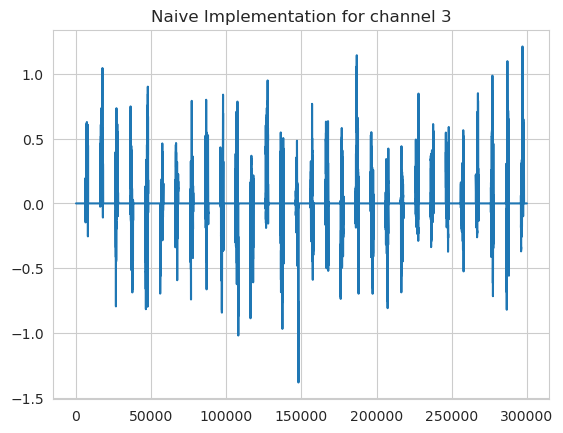

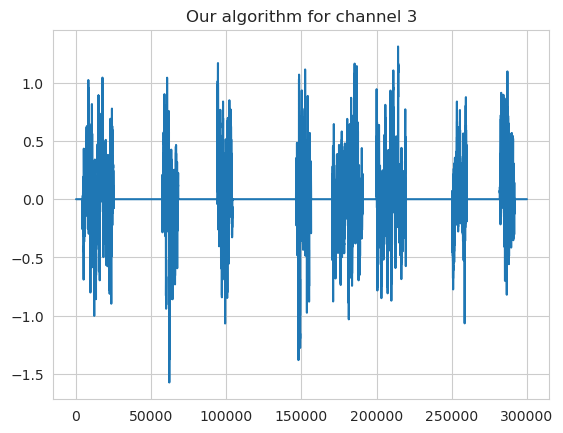

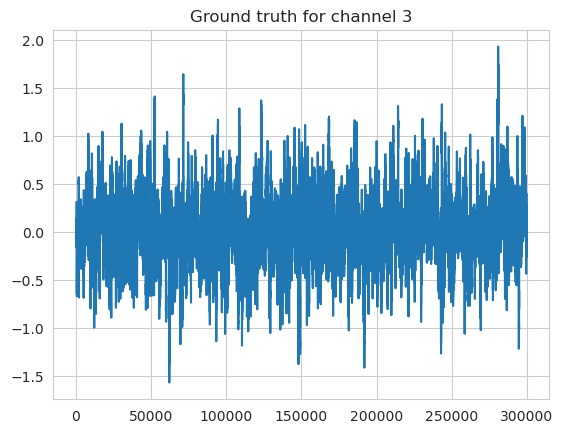

In [181]:
Wifi_output_data_after_interpolation_naive=get_sampled_channel(Wifi_naive_symbols,N)

channel_num=3

plt.title(f"Naive Implementation for channel {channel_num}")
plt.plot(Wifi_output_data_after_interpolation_naive[channel_num]['I'])
plt.show()
plt.title(f"Our algorithm for channel {channel_num}")
plt.plot(output_samples_for_each_channel[channel_num]['I'])
plt.show()
plt.title(f"Ground truth for channel {channel_num}")
plt.plot(Channel_dict[channel_num]["I"])

In [182]:
def finding_power(output_samples_for_each_channel, sample_time, num_channels, total_samples):
    """
    Compute per-channel power in fixed-size sample blocks and fill zeros
    between nonzero stretches with the average power of the previous stretch.

    Returns:
        power_per_channel: {
            channel_index: {
                'I': np.ndarray of shape (total_samples,),
                'Q': np.ndarray of shape (total_samples,)
            }
        }
    """
    sampleblock_length = int((0.5 / sample_time) // 10)
    power_per_channel = {}

    for i in range(num_channels):
        I_signal = np.array(output_samples_for_each_channel[i]['I'])
        Q_signal = np.array(output_samples_for_each_channel[i]['Q'])

        power_I = np.zeros(total_samples)
        power_Q = np.zeros(total_samples)

        nonzero_mask = (I_signal != 0) | (Q_signal != 0)
        diff_mask = np.diff(nonzero_mask.astype(int))
        starts = np.where(diff_mask == 1)[0] + 1  # rising edges
        ends = np.where(diff_mask == -1)[0] + 1   # falling edges

        # handle cases where signal starts or ends as nonzero
        if nonzero_mask[0]:
            starts = np.insert(starts, 0, 0)
        if nonzero_mask[-1]:
            ends = np.append(ends, total_samples)

        prev_end = 0
        avg_power_I = 0
        avg_power_Q = 0

        for s, e in zip(starts, ends):
            stretch_len = e - s
            n_blocks = int(np.ceil(stretch_len / sampleblock_length))

            block_powers_I = []
            block_powers_Q = []

            for b in range(n_blocks):
                start_idx = s + b * sampleblock_length
                end_idx = min(s + (b + 1) * sampleblock_length, e)

                I_block = I_signal[start_idx:end_idx]
                Q_block = Q_signal[start_idx:end_idx]

                block_power_I = np.mean(I_block**2)
                block_power_Q = np.mean(Q_block**2)

                power_I[start_idx:end_idx] = block_power_I
                power_Q[start_idx:end_idx] = block_power_Q

                block_powers_I.append(block_power_I)
                block_powers_Q.append(block_power_Q)

            avg_power_I = np.mean(block_powers_I)
            avg_power_Q = np.mean(block_powers_Q)

            # fill zeros before this stretch with average power from current stretch
            if prev_end < s:
                power_I[prev_end:s] = avg_power_I
                power_Q[prev_end:s] = avg_power_Q

            prev_end = e

        # fill tail after last stretch
        if prev_end < total_samples:
            power_I[prev_end:] = avg_power_I
            power_Q[prev_end:] = avg_power_Q

        power_per_channel[i] = {'I': power_I, 'Q': power_Q}

    return power_per_channel
def plot_power_and_signals(output_samples_for_each_channel, power_per_channel, num_channels_1):
    """
    Plot I/Q signals and their computed power for each channel.
    """
    fig, axs = plt.subplots(num_channels_1, 1, figsize=(12, 6), sharex=True)
    time_array=np.linspace(0,N*sample_time,N)
    for i in range(num_channels_1):
        # Extract data
        I_signal = np.array(output_samples_for_each_channel[i]['I'])
        power_I = power_per_channel[i]['I']
        samples = np.arange(len(I_signal))

        # --- I component ---
        axs[i].plot(time_array, power_I, color='crimson', linestyle='--', linewidth=2)
        axs[i].set_title(f"Channel {i}")
        axs[i].set_ylabel("Power")
        axs[i].set_xlabel("Time")
        axs[i].grid(True, linestyle='--', alpha=0.4)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

In [183]:
result = finding_power(output_samples_for_each_channel, sample_time, num_channels, total_samples)
result_naive = finding_power(Wifi_output_data_after_interpolation_naive, sample_time, num_channels, total_samples)
result_ground_truth = finding_power(Channel_dict, sample_time, num_channels, total_samples)

Our algorithm Power with time plot

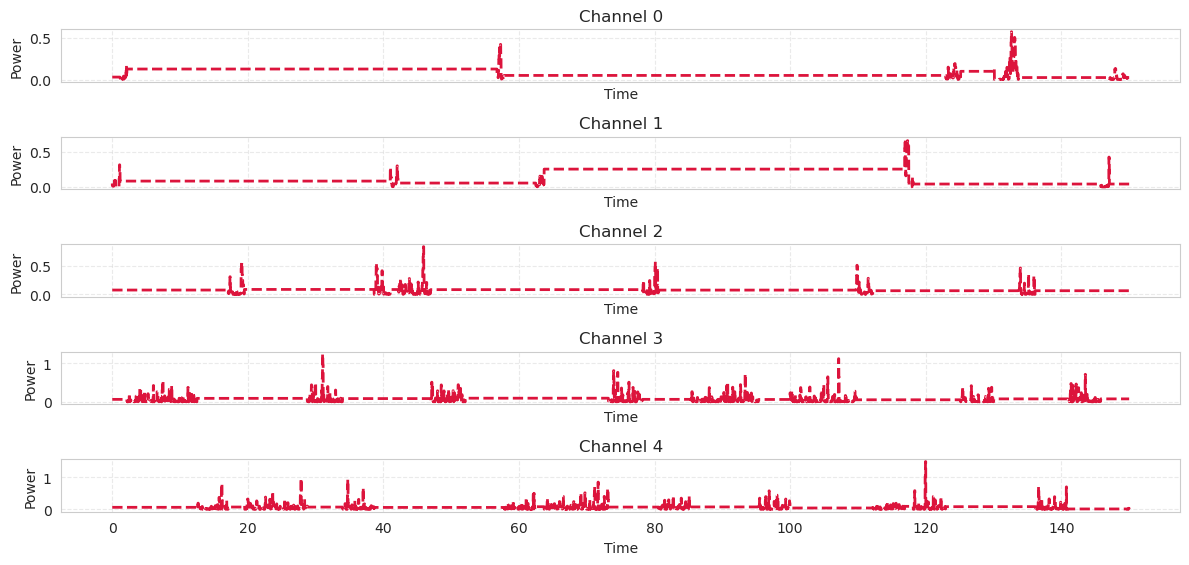

In [184]:
plot_power_and_signals(output_samples_for_each_channel, result, 5)

Naive algorithm power plot

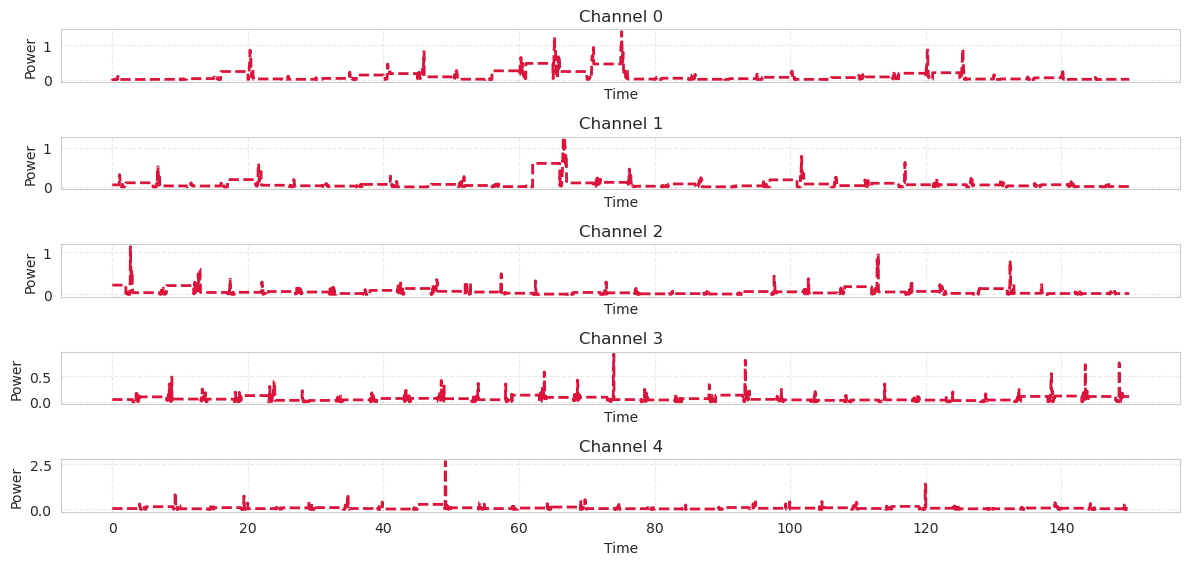

In [185]:
plot_power_and_signals(Wifi_output_data_after_interpolation_naive, result_naive, 5)

Ground truth Power plot

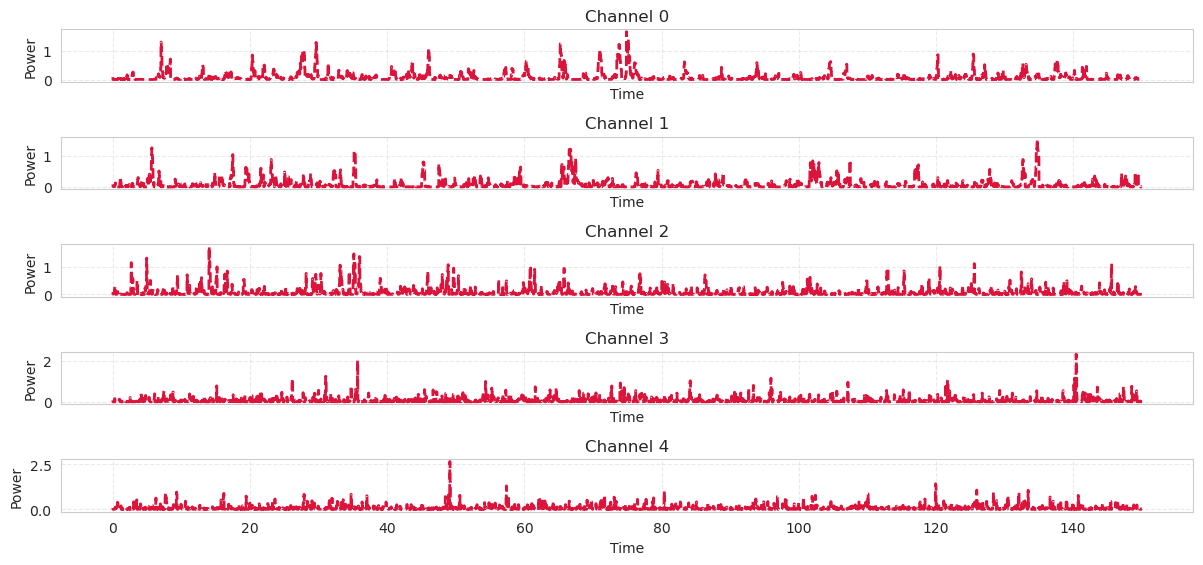

In [186]:
plot_power_and_signals(Channel_dict, result_ground_truth, 5)

In [187]:
def compute_power_differences(result, result_naive, result_ground_truth):
    """
    Compute elementwise differences of power arrays for each channel and component (I, Q)
    between result/result_naive and the ground truth.
    """
    diff_result = {}
    diff_naive = {}

    for ch in result.keys():
        diff_result[ch] = {
            'I': np.abs(result[ch]['I'] - result_ground_truth[ch]['I']),
            'Q': np.abs(result[ch]['Q'] - result_ground_truth[ch]['Q'])
        }
        diff_naive[ch] = {
            'I': np.abs(result_naive[ch]['I'] - result_ground_truth[ch]['I']),
            'Q': np.abs(result_naive[ch]['Q'] - result_ground_truth[ch]['Q'])
        }

    return diff_result, diff_naive


def plot_power_error_per_channel(diff_result, diff_naive, num_channels_to_plot):
    """
    Plot per-channel power errors (I and Q separately).
    Each channel gets two plots: I-error and Q-error.
    """
    fig, axs = plt.subplots(num_channels_to_plot, 2, figsize=(12, 3 * num_channels_to_plot), sharex=True)

    # Handle case where only one channel is plotted (so axs is 1D)
    if num_channels_to_plot == 1:
        axs = np.array([axs])

    for i in range(num_channels_to_plot):
    #for i in [7, 8, 9]: 
        samples = np.arange(len(diff_result[i]['I']))

        # ---- I component ----
        axs[i, 0].plot(samples, diff_result[i]['I'], label='Result vs GT', color='royalblue', linewidth=1.5)
        axs[i, 0].plot(samples, diff_naive[i]['I'], label='Naive vs GT', color='darkorange', linestyle='--', linewidth=1.5)
        axs[i, 0].set_title(f"Channel {i} - I Component Error")
        axs[i, 0].set_ylabel("Abs Power Difference")
        axs[i, 0].legend()
        axs[i, 0].grid(True, linestyle='--', alpha=0.5)

        # ---- Q component ----
        axs[i, 1].plot(samples, diff_result[i]['Q'], label='Result vs GT', color='royalblue', linewidth=1.5)
        axs[i, 1].plot(samples, diff_naive[i]['Q'], label='Naive vs GT', color='darkorange', linestyle='--', linewidth=1.5)
        axs[i, 1].set_title(f"Channel {i} - Q Component Error")
        axs[i, 1].legend()
        axs[i, 1].grid(True, linestyle='--', alpha=0.5)

    axs[-1, 0].set_xlabel("Sample Index")
    axs[-1, 1].set_xlabel("Sample Index")
    plt.suptitle("Error vs Ground Truth for Result and Naive Methods", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Compute differences
diff_result, diff_naive = compute_power_differences(result, result_naive, result_ground_truth)


In [188]:
import pandas as pd

def compute_average_power_difference(diff_result, diff_naive):
    """
    Compute average absolute power difference (scalar) for each channel and component (I, Q)
    from the already-computed difference dictionaries.

    Returns a pandas DataFrame for easy display and further analysis.
    """
    data = []

    for ch in diff_result.keys():
        avg_result_I = np.mean(diff_result[ch]['I'])
        avg_result_Q = np.mean(diff_result[ch]['Q'])
        avg_naive_I = np.mean(diff_naive[ch]['I'])
        avg_naive_Q = np.mean(diff_naive[ch]['Q'])

        data.append({
            'Channel': ch,
            'Avg |I_diff| (Result vs GT)': avg_result_I,
            'Avg |Q_diff| (Result vs GT)': avg_result_Q,
            'Avg |I_diff| (Naive vs GT)': avg_naive_I,
            'Avg |Q_diff| (Naive vs GT)': avg_naive_Q
        })

    df = pd.DataFrame(data)
    return df

avg_diff_df = compute_average_power_difference(diff_result, diff_naive)

print("Average Absolute Power Difference per Channel:")
print(avg_diff_df)

Average Absolute Power Difference per Channel:
   Channel  Avg |I_diff| (Result vs GT)  Avg |Q_diff| (Result vs GT)  \
0        0                     0.090014                     0.077206   
1        1                     0.126266                     0.115826   
2        2                     0.084028                     0.112492   
3        3                     0.062741                     0.073238   
4        4                     0.059461                     0.074660   

   Avg |I_diff| (Naive vs GT)  Avg |Q_diff| (Naive vs GT)  
0                    0.095781                    0.080171  
1                    0.082763                    0.095709  
2                    0.077026                    0.088982  
3                    0.066976                    0.087435  
4                    0.068410                    0.081567  


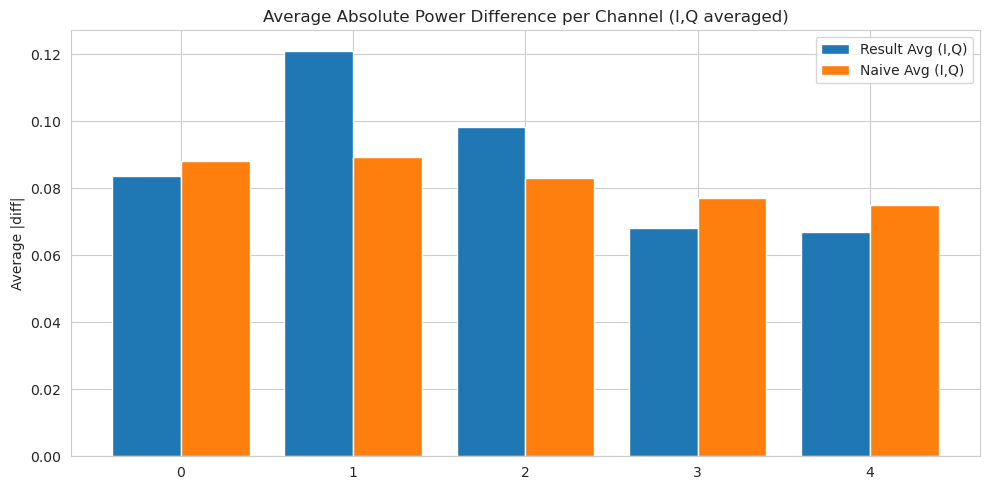

Our algorithm vs result total difference 0.005111208571172807


In [189]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Starting from avg_diff_df with columns:
# 'Channel', 'Avg |I_diff| (Result vs GT)', 'Avg |Q_diff| (Result vs GT)',
# 'Avg |I_diff| (Naive vs GT)', 'Avg |Q_diff| (Naive vs GT)'

# 1) Compute per-channel overall averages by averaging I and Q
avg_diff_df = avg_diff_df.copy()
avg_diff_df['Result Avg (I,Q)'] = (
    avg_diff_df['Avg |I_diff| (Result vs GT)'] + avg_diff_df['Avg |Q_diff| (Result vs GT)']
) / 2.0  
avg_diff_df['Naive Avg (I,Q)'] = (
    avg_diff_df['Avg |I_diff| (Naive vs GT)'] + avg_diff_df['Avg |Q_diff| (Naive vs GT)']
) / 2.0  

# Optional: sort channels if needed (numeric or lexical)
# avg_diff_df = avg_diff_df.sort_values('Channel')  

channels = avg_diff_df['Channel'].tolist()  
result_avg = avg_diff_df['Result Avg (I,Q)'].to_numpy()  
naive_avg  = avg_diff_df['Naive Avg (I,Q)'].to_numpy()   

x = np.arange(len(channels))  
bar_width = 0.4               

plt.figure(figsize=(10, 5))  
sns.set_style("whitegrid")  

# Two bars per channel: Result vs Naive
plt.bar(x - bar_width/2, result_avg, width=bar_width, label='Result Avg (I,Q)', color='#1f77b4')  
plt.bar(x + bar_width/2, naive_avg,  width=bar_width, label='Naive Avg (I,Q)',  color='#ff7f0e')  

plt.xticks(x, channels, rotation=0)  
plt.ylabel('Average |diff|')  
plt.title('Average Absolute Power Difference per Channel (I,Q averaged)')  
plt.legend(frameon=True)  
plt.tight_layout()  
plt.show()  

total_diff=np.mean(avg_diff_df['Result Avg (I,Q)']-avg_diff_df['Naive Avg (I,Q)'])
print("Our algorithm vs result total difference",total_diff)